In [2]:
#@title Dataset Definition

"""Smart Buildings Dataset implementation, including loading and downloading."""


import json
import pickle
import shutil
import numpy as np
import requests


class SmartBuildingsDataset:
 """Smart Buildings Dataset implementation, including loading and downloading."""


 def __init__(self, download=True):
   self.partitions = {
       "sb1": [
           "2022_a",
           "2022_b",
           "2023_a",
           "2023_b",
           "2024_a",
           
       ],
   }
   if download:
     self.download()


 def download(self):
   """Downloads the Smart Buildings Dataset from Google Cloud Storage."""
   print("Downloading data...")


   def download_file(url):
     local_filename = url.split("/")[-1]
     with requests.get(url, stream=True) as r:
       r.raise_for_status()
       with open(local_filename, "wb") as f:
         for chunk in r.iter_content(chunk_size=8192):
           f.write(chunk)
     return local_filename


   url = "https://storage.googleapis.com/gresearch/smart_buildings_dataset/tabular_data/sb1.zip"
   download_file(url)
   shutil.unpack_archive("sb1.zip", "sb1/")

 def get_floorplan(self, building):
   """Gets the floorplan and device layout map for a specific building.


   Args:
     building: The name of the building.


   Returns:
     A tuple containing the floorplan and device layout map.
   """
   if building not in self.partitions.keys():
     raise ValueError("invalid building")
   floorplan = np.load(f"./{building}/tabular/floorplan.npy")

   def gdrive_to_direct_url(share_url):
        file_id = share_url.split('/d/')[1].split('/')[0]
        return f"https://drive.google.com/uc?export=download&id={file_id}"
   share_url = "https://drive.google.com/file/d/19W4exC1IfIpx6x_agZy3HO1ARXdxKnic/view?usp=sharing"
   direct_url = gdrive_to_direct_url(share_url)
   response = requests.get(direct_url)
   device_layout_map = response.json()

   return floorplan, device_layout_map


 def get_building_data(self, building, partition):
   """Gets the data for a specific building and partition.


   Args:
     building: The name of the building.
     partition: The name of the partition.


   Returns:
     A tuple containing the data and metadata.
   """
   if building not in self.partitions.keys():
     raise ValueError("invalid building")
   if partition not in self.partitions[building]:
     raise ValueError("invalid partition")
   path = f"./{building}/tabular/{building}/{partition}/"


   data = np.load(path + "data.npy.npz")
   metadata = pickle.load(open(path + "metadata.pickle", "rb"))


   if "device_infos" not in metadata.keys():
     metadata["device_infos"] = pickle.load(
         open(f"./{building}/tabular/device_info_dicts.pickle", "rb")
     )
   if "zone_infos" not in metadata.keys():
     metadata["zone_infos"] = pickle.load(
         open(f"./{building}/tabular/zone_info_dicts.pickle", "rb")
     )
   return data, metadata


In [3]:
#@title Data download and splitting

ds = SmartBuildingsDataset()

# training data: Jan-June 2022
data, metadata = ds.get_building_data("sb1","2022_a")
floorplan, device_layout_map = ds.get_floorplan("sb1")

# validation data: July-December 2022
data_val, metadata_val = ds.get_building_data("sb1","2022_b")
floorplan_val, device_layout_map_val = ds.get_floorplan("sb1")

# lets split validation data into things to predict, and exogenous variables
indexes = [v for k, v in metadata_val['observation_ids'].items() if "zone_air_temperature_sensor" in k]
temp_data = data_val['observation_value_matrix'][:, indexes]
matching_items = [(k, v) for k, v in metadata_val['observation_ids'].items() if "zone_air_temperature_sensor" in k]
temp_data_ids = {k: i for i, (k, v) in enumerate(matching_items)}

indexes = [v for k, v in metadata_val['observation_ids'].items() if "zone_air_temperature_sensor" not in k]
exogenous_observation_data = data_val['observation_value_matrix'][:, indexes]
matching_items = [(k, v) for k, v in metadata_val['observation_ids'].items() if "zone_air_temperature_sensor" not in k]
exogenous_observation_data_ids = {k: i for i, (k, v) in enumerate(matching_items)}

initial_condition = temp_data[0]

# Train data:
data['observation_value_matrix'] <br />
metadata["observation_ids"]<br />
metadata["observation_timestamps"]<br />
<br />
data['action_value_matrix']<br />
metadata["action_ids"]<br />

floorplan
device_layout_map
metadata["device_infos"]

# Validation data:
data_val['action_value_matrix']<br />
metadata_val["action_ids"]<br />
metadata_val["observation_timestamps"]<br />
floorplan
device_layout_map

exogenous_observation_data<br />
exogenous_observation_data_ids<br />
initial_condition

# Predict:
temp_data <br />
temp_data_ids


## Exploratory Data Analysis

In [4]:
data['observation_value_matrix'].shape

(51852, 1198)

In [5]:
data['action_value_matrix'].shape

(51852, 3)

In [6]:
print(data['action_value_matrix'][0], data['action_value_matrix'][3000])

[288.70370483 310.92593384 291.48147583] [290.37036133 352.59259033 291.48147583]


In [7]:
metadata['action_ids']

{'12945159110931775488@supply_air_temperature_setpoint': 0,
 '13761436543392677888@supply_water_temperature_setpoint': 1,
 '14409954889734029312@supply_air_temperature_setpoint': 2}

In [8]:
metadata["observation_ids"]

{'202194278473007104@building_air_static_pressure_setpoint': 0,
 '202194278473007104@building_air_static_pressure_sensor': 1,
 '202194278473007104@outside_air_flowrate_sensor': 2,
 '202194278473007104@exhaust_air_damper_percentage_command': 3,
 '202194278473007104@cooling_percentage_command': 4,
 '202194278473007104@supply_air_temperature_setpoint': 5,
 '202194278473007104@return_air_temperature_sensor': 6,
 '202194278473007104@supply_fan_speed_percentage_command': 7,
 '202194278473007104@supply_fan_speed_frequency_sensor': 8,
 '202194278473007104@mixed_air_temperature_sensor': 9,
 '202194278473007104@supply_air_static_pressure_sensor': 10,
 '202194278473007104@outside_air_flowrate_setpoint': 11,
 '202194278473007104@exhaust_fan_speed_frequency_sensor': 12,
 '202194278473007104@exhaust_fan_speed_percentage_command': 13,
 '202194278473007104@mixed_air_temperature_setpoint': 14,
 '202194278473007104@supply_air_temperature_sensor': 15,
 '202194278473007104@outside_air_damper_percentage_co

In [9]:
initial_condition.shape

(123,)

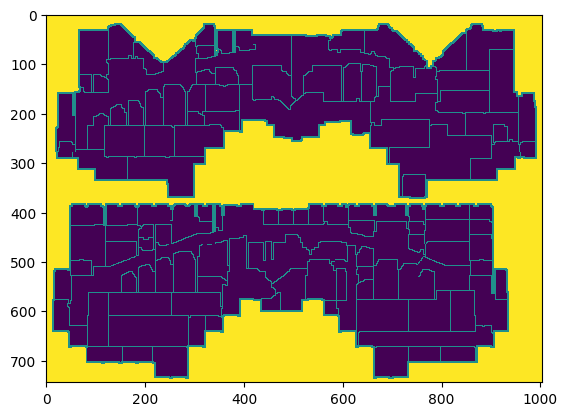

In [10]:
from matplotlib import pyplot as plt
plt.imshow(floorplan, interpolation='nearest')
plt.show()

In [11]:
device_layout_map.keys()

dict_keys(['exterior_space', '1-13', '1-21', '1-46', '1-29', '1-12', '1-20', '1-22', '1-25', '1-28', '1-23', '1-26', '1-15', '1-14', '', '1-17', '1-32', '1-44', '1-43', '1-27', '1-18', '1-16', '1-31', '1-11', '1-10', '1-52', '1-50', '1-19', '1-47', '1-33', '1-09', '1-30', '1-08', '1-07', '1-48', '1-51', '1-34', '1-05', '1-42', '1-53', '1-39', '1-35', '1-04', '1-54', '1-37', '1-03', '1-36', '1-02', '1-55', '1-40', '2-19', '2-20', '2-21', '2-12', '2-22', '2-23', '2-27', '2-28', '2-42', '2-30', '2-31', '2-32', '2-24', '2-25', '2-26', '2-38', '2-33', '2-43', '2-39', '2-16', '2-18', '2-14', '2-40', '2-34', '2-64', '2-13', '2-10', '2-17', '2-37', '2-57', '2-44', '2-5', '2-9', '2-36', '2-8', '2-15', '2-61', '2-46', '2-35', '2-47', '2-7', '2-72', '2-60', '2-48', '2-6', '2-49', '2-65', '2-45', '2-50', '2-4', '2-3', '2-66', '2-59', '2-2', '2-51', '2-58', '2-68', '2-69', '2-67', '2-56', '2-1', '2-71', '2-70', '2-55', '2-54', '2-53', 'unrecognized'])

In [12]:
temp_data.shape

(53292, 123)

## Dataset Configuration for Models


### Extract the Desired Data Fields

In [13]:
data_train, metadata_train = data, metadata

temp_indexes = [v for k, v in metadata_train['observation_ids'].items()
                if "zone_air_temperature_sensor" in k]
temp_data_train = data_train['observation_value_matrix'][:, temp_indexes]
temp_data_train_ids = {
    k: i for i, (k, v) in enumerate(
        [(k, v) for k, v in metadata_train['observation_ids'].items()
         if "zone_air_temperature_sensor" in k]
    )
}

exog_train_indexes = [v for k, v in metadata_train['observation_ids'].items()
                if "zone_air_temperature_sensor" not in k]
exogenous_observation_data_train = data_train['observation_value_matrix'][:, exog_train_indexes]
exogenous_observation_data_train_ids = {
    k: i for i, (k, v) in enumerate(
        [(k, v) for k, v in metadata_train['observation_ids'].items()
         if "zone_air_temperature_sensor" not in k]
    )
}

action_data_train = data_train['action_value_matrix']

### Extract the final month (June, 2022) from the training data

In [14]:
train_temp = temp_data_train[-8640:]
train_exog = exogenous_observation_data_train[-8640:]
train_actions = action_data_train[-8640:]


print(train_temp.shape)
print(train_exog.shape)
print(train_actions.shape)

(8640, 123)
(8640, 1075)
(8640, 3)


### Create Dataset for Storing and Accessing the Seq2Seq SB Data

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import random
from typing import Dict, Tuple, Optional
import math
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [21]:
class BuildingDataset(Dataset):
    def __init__(self, 
                 temp_data: np.ndarray,
                 exog_data: np.ndarray, 
                 action_data: np.ndarray,
                 min_history: int = 288,  # 1 day minimum
                 max_forecast: int = 2015,  # 7 days maximum
                 curriculum_stage: int = 0):
        
        self.temp_data = temp_data  # [8640, 123]
        self.exog_data = exog_data  # [8640, 1075]
        self.action_data = action_data  # [8640, 3]
        
        self.min_history = min_history
        self.max_forecast = max_forecast
        
        # Curriculum learning stages
        self.curriculum_stages = [
            {'min_forecast': 288, 'max_forecast': 576},    # 1-2 days
            {'min_forecast': 288, 'max_forecast': 1152},   # 1-4 days
            {'min_forecast': 288, 'max_forecast': 2015},   # 1-7 days
            {'min_forecast': 1152, 'max_forecast': 2015},  # 4-7 days
        ]
        
        self.set_curriculum_stage(curriculum_stage)
        
        # Valid indices for sampling
        self.valid_indices = list(range(self.min_history, 
                                      len(temp_data) - self.max_forecast))
        
    def set_curriculum_stage(self, stage: int):
        """Set curriculum learning stage"""
        if stage < len(self.curriculum_stages):
            self.current_stage = self.curriculum_stages[stage]
        else:
            self.current_stage = self.curriculum_stages[-1]
    
    def __len__(self):
        return len(self.valid_indices)
    
    def __getitem__(self, idx):
        actual_idx = self.valid_indices[idx]
        
        # Variable context window length (up to available history)
        max_possible_history = actual_idx
        context_length = min(max_possible_history, 
                           random.randint(self.min_history, min(2000, max_possible_history)))
        
        # Variable forecast length based on curriculum
        min_forecast = self.current_stage['min_forecast']
        max_forecast = min(self.current_stage['max_forecast'], 
                          len(self.temp_data) - actual_idx - 1)
        
        forecast_length = random.randint(min_forecast, max_forecast)
        
        return {
            'historical_temps': torch.tensor(
                self.temp_data[actual_idx-context_length:actual_idx], 
                dtype=torch.float32
            ),
            'historical_exog': torch.tensor(
                self.exog_data[actual_idx-context_length:actual_idx], 
                dtype=torch.float32
            ),
            'historical_actions': torch.tensor(
                self.action_data[actual_idx-context_length:actual_idx], 
                dtype=torch.float32
            ),
            'initial_temp': torch.tensor(
                self.temp_data[actual_idx], 
                dtype=torch.float32
            ),
            'future_exog': torch.tensor(
                self.exog_data[actual_idx+1:actual_idx+1+forecast_length], 
                dtype=torch.float32
            ),
            'future_actions': torch.tensor(
                self.action_data[actual_idx+1:actual_idx+1+forecast_length], 
                dtype=torch.float32
            ),
            'target_temps': torch.tensor(
                self.temp_data[actual_idx+1:actual_idx+1+forecast_length], 
                dtype=torch.float32
            )
        }

In [22]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, max_len: int = 10000):
        super().__init__()
        
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        self.register_buffer('pe', pe)
    
    def forward(self, x):
        return x + self.pe[:x.size(1)].unsqueeze(0)

class BuildingTempPredictor(nn.Module):
    def __init__(self, 
                 temp_dim: int = 123,
                 exog_dim: int = 1075, 
                 action_dim: int = 3,
                 d_model: int = 512,
                 nhead: int = 8,
                 num_encoder_layers: int = 4,
                 num_decoder_layers: int = 4,
                 dropout: float = 0.1):
        
        super().__init__()
        
        self.d_model = d_model
        
        # Input encoders
        self.temp_encoder = nn.Linear(temp_dim, d_model)
        self.exog_encoder = nn.Linear(exog_dim, d_model)
        self.action_encoder = nn.Linear(action_dim, d_model)
        
        # Positional encoding
        self.pos_encoder = PositionalEncoding(d_model)
        
        # Layer norm
        self.norm = nn.LayerNorm(d_model)
        
        # Transformer encoder for historical context
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=d_model * 4,
            dropout=dropout,
            batch_first=True
        )
        self.history_transformer = nn.TransformerEncoder(
            encoder_layer, 
            num_layers=num_encoder_layers
        )
        
        # Transformer decoder for prediction
        decoder_layer = nn.TransformerDecoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=d_model * 4,
            dropout=dropout,
            batch_first=True
        )
        self.prediction_transformer = nn.TransformerDecoder(
            decoder_layer,
            num_layers=num_decoder_layers
        )
        
        # Output projection
        self.output_projection = nn.Sequential(
            nn.Linear(d_model, d_model // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model // 2, temp_dim)
        )
        
        # Initialize weights
        self.apply(self._init_weights)
    
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
    
    def create_padding_mask(self, seq_len: int, actual_len: int) -> torch.Tensor:
        """Create padding mask for variable length sequences"""
        mask = torch.zeros(seq_len, dtype=torch.bool)
        if actual_len < seq_len:
            mask[actual_len:] = True
        return mask
    
    def forward(self, 
                historical_temps: torch.Tensor,
                historical_exog: torch.Tensor,
                historical_actions: torch.Tensor,
                initial_temp: torch.Tensor,
                future_exog: torch.Tensor,
                future_actions: torch.Tensor) -> torch.Tensor:
        
        batch_size = historical_temps.shape[0]
        history_len = historical_temps.shape[1]
        forecast_len = future_exog.shape[1]
        
        # Encode historical sequence
        hist_temp_emb = self.temp_encoder(historical_temps)
        hist_exog_emb = self.exog_encoder(historical_exog)
        hist_action_emb = self.action_encoder(historical_actions)
        
        # Combine historical features
        hist_combined = hist_temp_emb + hist_exog_emb + hist_action_emb
        hist_combined = self.pos_encoder(hist_combined)
        hist_combined = self.norm(hist_combined)
        
        # Process historical context
        memory = self.history_transformer(hist_combined)
        
        # Prepare future inputs
        future_exog_emb = self.exog_encoder(future_exog)
        future_action_emb = self.action_encoder(future_actions)
        future_combined = future_exog_emb + future_action_emb
        
        # Add initial temperature as first token
        initial_emb = self.temp_encoder(initial_temp).unsqueeze(1)
        
        # Create decoder input sequence
        decoder_input = torch.cat([initial_emb, future_combined], dim=1)
        decoder_input = self.pos_encoder(decoder_input)
        decoder_input = self.norm(decoder_input)
        
        # Generate predictions using decoder
        output = self.prediction_transformer(
            decoder_input[:, :-1],  # Exclude last token
            memory
        )
        
        # Project to temperature space
        predictions = self.output_projection(output)
        
        return predictions

In [23]:
def collate_fn(batch):
    """Custom collate function for variable length sequences"""
    
    # Find max lengths
    max_history = max(item['historical_temps'].shape[0] for item in batch)
    max_forecast = max(item['future_exog'].shape[0] for item in batch)
    
    batch_size = len(batch)
    
    # Initialize tensors
    historical_temps = torch.zeros(batch_size, max_history, 123)
    historical_exog = torch.zeros(batch_size, max_history, 1075)
    historical_actions = torch.zeros(batch_size, max_history, 3)
    initial_temps = torch.zeros(batch_size, 123)
    future_exog = torch.zeros(batch_size, max_forecast, 1075)
    future_actions = torch.zeros(batch_size, max_forecast, 3)
    target_temps = torch.zeros(batch_size, max_forecast, 123)
    
    # Fill tensors
    for i, item in enumerate(batch):
        hist_len = item['historical_temps'].shape[0]
        fore_len = item['future_exog'].shape[0]
        
        historical_temps[i, :hist_len] = item['historical_temps']
        historical_exog[i, :hist_len] = item['historical_exog']
        historical_actions[i, :hist_len] = item['historical_actions']
        initial_temps[i] = item['initial_temp']
        future_exog[i, :fore_len] = item['future_exog']
        future_actions[i, :fore_len] = item['future_actions']
        target_temps[i, :fore_len] = item['target_temps']
    
    return {
        'historical_temps': historical_temps,
        'historical_exog': historical_exog,
        'historical_actions': historical_actions,
        'initial_temp': initial_temps,
        'future_exog': future_exog,
        'future_actions': future_actions,
        'target_temps': target_temps
    }

In [24]:
def train_epoch(model: nn.Module, 
                train_loader: DataLoader, 
                optimizer: torch.optim.Optimizer,
                device: torch.device,
                epoch: int) -> float:
    """Train for one epoch"""
    model.train()
    total_loss = 0.0
    num_batches = len(train_loader)
    
    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch}')
    
    for batch_idx, batch in enumerate(progress_bar):
        # Move to device
        batch = {k: v.to(device) for k, v in batch.items()}
        
        optimizer.zero_grad()
        
        # Forward pass
        predictions = model(
            batch['historical_temps'],
            batch['historical_exog'],
            batch['historical_actions'], 
            batch['initial_temp'],
            batch['future_exog'],
            batch['future_actions']
        )
        
        # Compute loss
        loss = F.mse_loss(predictions, batch['target_temps'])
        
        # Backward pass
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        total_loss += loss.item()
        progress_bar.set_postfix({'loss': loss.item()})
    
    return total_loss / num_batches

def validate_model(model: nn.Module, val_loader: DataLoader, device: torch.device) -> Dict[str, float]:
    """Validate model"""
    model.eval()
    total_loss = 0.0
    total_mae = 0.0
    num_batches = len(val_loader)
    
    with torch.no_grad():
        for batch in val_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            
            predictions = model(
                batch['historical_temps'],
                batch['historical_exog'],
                batch['historical_actions'],
                batch['initial_temp'],
                batch['future_exog'],
                batch['future_actions']
            )
            
            loss = F.mse_loss(predictions, batch['target_temps'])
            mae = F.l1_loss(predictions, batch['target_temps'])
            
            total_loss += loss.item()
            total_mae += mae.item()
    
    return {
        'val_loss': total_loss / num_batches,
        'val_mae': total_mae / num_batches
    }

def evaluate_final(model: nn.Module,
                   full_history_temps: torch.Tensor,
                   full_history_exog: torch.Tensor,
                   full_history_actions: torch.Tensor,
                   initial_condition: torch.Tensor,
                   future_exog: torch.Tensor,
                   future_actions: torch.Tensor,
                   device: torch.device) -> torch.Tensor:
    """Final evaluation using full month history"""
    model.eval()
    
    with torch.no_grad():
        # Add batch dimension
        full_history_temps = full_history_temps.unsqueeze(0).to(device)
        full_history_exog = full_history_exog.unsqueeze(0).to(device)
        full_history_actions = full_history_actions.unsqueeze(0).to(device)
        initial_condition = initial_condition.unsqueeze(0).to(device)
        future_exog = future_exog.unsqueeze(0).to(device)
        future_actions = future_actions.unsqueeze(0).to(device)
        
        predictions = model(
            full_history_temps,
            full_history_exog,
            full_history_actions,
            initial_condition,
            future_exog[:, :2015],  # Only predict 2015 steps
            future_actions[:, :2015]
        )
    
    return predictions.squeeze(0)

In [25]:
class Config:
    # Model parameters
    temp_dim = 123
    exog_dim = 1075
    action_dim = 3
    d_model = 512
    nhead = 8
    num_encoder_layers = 4
    num_decoder_layers = 4
    dropout = 0.1
    
    # Training parameters
    batch_size = 8
    learning_rate = 1e-4
    weight_decay = 1e-5
    
    # Curriculum learning stages
    curriculum_schedule = [
        {'epochs': 15, 'stage': 0},  # 1-2 days
        {'epochs': 20, 'stage': 1},  # 1-4 days
        {'epochs': 25, 'stage': 2},  # 1-7 days
        {'epochs': 30, 'stage': 3},  # 4-7 days
    ]

In [26]:
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

config = Config()

# Create model
model = BuildingTempPredictor(
    temp_dim=config.temp_dim,
    exog_dim=config.exog_dim,
    action_dim=config.action_dim,
    d_model=config.d_model,
    nhead=config.nhead,
    num_encoder_layers=config.num_encoder_layers,
    num_decoder_layers=config.num_decoder_layers,
    dropout=config.dropout
).to(device)

print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

# Create datasets
train_dataset = BuildingDataset(
    train_temp,
    train_exog,
    train_actions,
    min_history=288,
    max_forecast=2015,
    curriculum_stage=0
)

# Split dataset for validation
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size

train_indices = list(range(train_size))
val_indices = list(range(train_size, train_size + val_size))

train_subset = torch.utils.data.Subset(train_dataset, train_indices)
val_subset = torch.utils.data.Subset(train_dataset, val_indices)

# Create data loaders
train_loader = DataLoader(
    train_subset,
    batch_size=config.batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=2,
    pin_memory=True
)

val_loader = DataLoader(
    val_subset,
    batch_size=config.batch_size,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=2,
    pin_memory=True
)

# Optimizer and scheduler
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=config.learning_rate,
    weight_decay=config.weight_decay
)

scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=config.learning_rate,
    total_steps=sum(stage['epochs'] for stage in config.curriculum_schedule) * len(train_loader),
    pct_start=0.3,
    anneal_strategy='cos'
)

# Training loop with curriculum learning
best_val_loss = float('inf')
epoch = 0

for stage in config.curriculum_schedule:
    print(f"\n=== Curriculum Stage {stage['stage']} ===")
    
    # Update dataset curriculum stage
    train_dataset.set_curriculum_stage(stage['stage'])
    
    for stage_epoch in range(stage['epochs']):
        epoch += 1
        
        # Train
        train_loss = train_epoch(model, train_loader, optimizer, device, epoch)
        
        # Validate
        val_metrics = validate_model(model, val_loader, device)
        
        # Update scheduler
        scheduler.step()
        
        print(f"Epoch {epoch}: Train Loss: {train_loss:.4f}, "
                f"Val Loss: {val_metrics['val_loss']:.4f}, "
                f"Val MAE: {val_metrics['val_mae']:.4f}")
        
        # Save best model
        if val_metrics['val_loss'] < best_val_loss:
            best_val_loss = val_metrics['val_loss']
            torch.save(model.state_dict(), 'best_model.pth')
            print(f"New best model saved with val_loss: {best_val_loss:.4f}")

# Load best model for final evaluation
model.load_state_dict(torch.load('best_model.pth'))

# Final evaluation
print("\n=== Final Evaluation ===")

# Convert training data to tensors
full_history_temps = torch.tensor(train_temp, dtype=torch.float32)
full_history_exog = torch.tensor(train_exog, dtype=torch.float32)
full_history_actions = torch.tensor(train_actions, dtype=torch.float32)

initial_condition_tensor = torch.tensor(initial_condition, dtype=torch.float32)
exog_future_tensor = torch.tensor(exogenous_observation_data[:2016], dtype=torch.float32)  # [2016, 1098]
actions_future_tensor = torch.tensor(data_val['action_value_matrix'][:2016], dtype=torch.float32)  # [2016, 3]

# Generate final predictions
final_predictions = evaluate_final(
    model,
    full_history_temps,
    full_history_exog,
    full_history_actions,
    initial_condition_tensor,
    exog_future_tensor,
    actions_future_tensor,
    device
)

print(f"Final predictions shape: {final_predictions.shape}")
print(f"Temperature range: [{final_predictions.min():.2f}, {final_predictions.max():.2f}]")

# Save predictions
torch.save(final_predictions, 'final_predictions.pth')
np.save('final_predictions.npy', final_predictions.cpu().numpy())

print("Training completed!")


Using device: cuda
Model parameters: 30,206,075

=== Curriculum Stage 0 ===


Epoch 1: 100%|██████████| 634/634 [03:19<00:00,  3.17it/s, loss=3.57e+3]


Epoch 1: Train Loss: 3629.9469, Val Loss: 1935.1604, Val MAE: 25.1357
New best model saved with val_loss: 1935.1604


Epoch 2: 100%|██████████| 634/634 [03:25<00:00,  3.09it/s, loss=3.89e+3]


Epoch 2: Train Loss: 3499.6610, Val Loss: 1841.0073, Val MAE: 23.9952
New best model saved with val_loss: 1841.0073


Epoch 3: 100%|██████████| 634/634 [03:24<00:00,  3.10it/s, loss=3.34e+3]


Epoch 3: Train Loss: 3254.3575, Val Loss: 1694.3759, Val MAE: 23.0666
New best model saved with val_loss: 1694.3759


Epoch 4: 100%|██████████| 634/634 [03:24<00:00,  3.09it/s, loss=2.42e+3]


Epoch 4: Train Loss: 2948.9079, Val Loss: 1542.2183, Val MAE: 22.3112
New best model saved with val_loss: 1542.2183


Epoch 5: 100%|██████████| 634/634 [03:28<00:00,  3.05it/s, loss=1.98e+3]


Epoch 5: Train Loss: 2572.2230, Val Loss: 1323.1475, Val MAE: 20.6749
New best model saved with val_loss: 1323.1475


Epoch 6: 100%|██████████| 634/634 [03:25<00:00,  3.09it/s, loss=2.47e+3]


Epoch 6: Train Loss: 2151.0977, Val Loss: 1076.0836, Val MAE: 18.4912
New best model saved with val_loss: 1076.0836


Epoch 7: 100%|██████████| 634/634 [03:25<00:00,  3.09it/s, loss=1.42e+3]


Epoch 7: Train Loss: 1728.3945, Val Loss: 860.3639, Val MAE: 16.5115
New best model saved with val_loss: 860.3639


Epoch 8: 100%|██████████| 634/634 [03:24<00:00,  3.10it/s, loss=942]    


Epoch 8: Train Loss: 1307.2846, Val Loss: 660.9065, Val MAE: 14.2406
New best model saved with val_loss: 660.9065


Epoch 9: 100%|██████████| 634/634 [03:26<00:00,  3.07it/s, loss=920]    


Epoch 9: Train Loss: 922.2637, Val Loss: 493.4813, Val MAE: 11.6937
New best model saved with val_loss: 493.4813


Epoch 10: 100%|██████████| 634/634 [03:24<00:00,  3.10it/s, loss=635]


Epoch 10: Train Loss: 604.6183, Val Loss: 376.0935, Val MAE: 8.9523
New best model saved with val_loss: 376.0935


Epoch 11: 100%|██████████| 634/634 [03:25<00:00,  3.09it/s, loss=341]


Epoch 11: Train Loss: 392.8598, Val Loss: 316.9975, Val MAE: 6.5487
New best model saved with val_loss: 316.9975


Epoch 12: 100%|██████████| 634/634 [03:25<00:00,  3.09it/s, loss=230] 


Epoch 12: Train Loss: 280.9926, Val Loss: 227.8889, Val MAE: 4.7011
New best model saved with val_loss: 227.8889


Epoch 13: 100%|██████████| 634/634 [03:24<00:00,  3.11it/s, loss=264] 


Epoch 13: Train Loss: 234.9533, Val Loss: 213.2380, Val MAE: 4.2288
New best model saved with val_loss: 213.2380


Epoch 14: 100%|██████████| 634/634 [03:26<00:00,  3.06it/s, loss=184] 


Epoch 14: Train Loss: 211.6365, Val Loss: 202.5228, Val MAE: 4.1983
New best model saved with val_loss: 202.5228


Epoch 15: 100%|██████████| 634/634 [03:25<00:00,  3.08it/s, loss=210] 


Epoch 15: Train Loss: 192.6898, Val Loss: 187.2942, Val MAE: 4.0430
New best model saved with val_loss: 187.2942

=== Curriculum Stage 1 ===


Epoch 16: 100%|██████████| 634/634 [04:28<00:00,  2.36it/s, loss=166] 


Epoch 16: Train Loss: 141.3053, Val Loss: 163.7239, Val MAE: 3.6285
New best model saved with val_loss: 163.7239


Epoch 17: 100%|██████████| 634/634 [04:29<00:00,  2.35it/s, loss=69.3]


Epoch 17: Train Loss: 122.0612, Val Loss: 153.6995, Val MAE: 3.6484
New best model saved with val_loss: 153.6995


Epoch 18: 100%|██████████| 634/634 [04:28<00:00,  2.37it/s, loss=90.2]


Epoch 18: Train Loss: 102.6649, Val Loss: 137.6499, Val MAE: 3.5059
New best model saved with val_loss: 137.6499


Epoch 19: 100%|██████████| 634/634 [04:28<00:00,  2.36it/s, loss=72.5]


Epoch 19: Train Loss: 84.3840, Val Loss: 125.2601, Val MAE: 3.4495
New best model saved with val_loss: 125.2601


Epoch 20: 100%|██████████| 634/634 [04:29<00:00,  2.35it/s, loss=58.3]


Epoch 20: Train Loss: 66.6609, Val Loss: 113.6069, Val MAE: 3.3746
New best model saved with val_loss: 113.6069


Epoch 21: 100%|██████████| 634/634 [04:29<00:00,  2.35it/s, loss=78.6]


Epoch 21: Train Loss: 52.1282, Val Loss: 101.4580, Val MAE: 3.2081
New best model saved with val_loss: 101.4580


Epoch 22: 100%|██████████| 634/634 [04:28<00:00,  2.36it/s, loss=20]  


Epoch 22: Train Loss: 41.0610, Val Loss: 92.1406, Val MAE: 3.1106
New best model saved with val_loss: 92.1406


Epoch 23: 100%|██████████| 634/634 [04:29<00:00,  2.35it/s, loss=82.4]


Epoch 23: Train Loss: 35.1649, Val Loss: 86.6238, Val MAE: 3.0912
New best model saved with val_loss: 86.6238


Epoch 24: 100%|██████████| 634/634 [04:31<00:00,  2.33it/s, loss=25.7]


Epoch 24: Train Loss: 31.8392, Val Loss: 85.2848, Val MAE: 3.1281
New best model saved with val_loss: 85.2848


Epoch 25: 100%|██████████| 634/634 [04:28<00:00,  2.36it/s, loss=12.6]


Epoch 25: Train Loss: 29.5517, Val Loss: 79.4325, Val MAE: 2.9855
New best model saved with val_loss: 79.4325


Epoch 26: 100%|██████████| 634/634 [04:29<00:00,  2.35it/s, loss=35.4]


Epoch 26: Train Loss: 28.2332, Val Loss: 78.3360, Val MAE: 2.9509
New best model saved with val_loss: 78.3360


Epoch 27: 100%|██████████| 634/634 [04:28<00:00,  2.36it/s, loss=52.9]


Epoch 27: Train Loss: 26.8279, Val Loss: 78.3775, Val MAE: 2.9567


Epoch 28: 100%|██████████| 634/634 [04:29<00:00,  2.35it/s, loss=19.4]


Epoch 28: Train Loss: 25.4303, Val Loss: 76.8318, Val MAE: 2.8898
New best model saved with val_loss: 76.8318


Epoch 29: 100%|██████████| 634/634 [04:28<00:00,  2.36it/s, loss=38.5]


Epoch 29: Train Loss: 24.6558, Val Loss: 76.5612, Val MAE: 2.8938
New best model saved with val_loss: 76.5612


Epoch 30: 100%|██████████| 634/634 [04:28<00:00,  2.36it/s, loss=13.4]


Epoch 30: Train Loss: 24.1593, Val Loss: 79.0216, Val MAE: 2.9564


Epoch 31: 100%|██████████| 634/634 [04:29<00:00,  2.35it/s, loss=17.4]


Epoch 31: Train Loss: 23.6807, Val Loss: 72.8366, Val MAE: 2.7619
New best model saved with val_loss: 72.8366


Epoch 32: 100%|██████████| 634/634 [04:31<00:00,  2.33it/s, loss=32.3]


Epoch 32: Train Loss: 23.0852, Val Loss: 72.8747, Val MAE: 2.7359


Epoch 33: 100%|██████████| 634/634 [04:28<00:00,  2.36it/s, loss=31.9]


Epoch 33: Train Loss: 23.2735, Val Loss: 72.6056, Val MAE: 2.6320
New best model saved with val_loss: 72.6056


Epoch 34: 100%|██████████| 634/634 [04:29<00:00,  2.36it/s, loss=10.2]


Epoch 34: Train Loss: 22.3016, Val Loss: 73.1826, Val MAE: 2.6520


Epoch 35: 100%|██████████| 634/634 [04:31<00:00,  2.33it/s, loss=16.8]


Epoch 35: Train Loss: 22.4009, Val Loss: 73.1546, Val MAE: 2.6392

=== Curriculum Stage 2 ===


Epoch 36: 100%|██████████| 634/634 [06:28<00:00,  1.63it/s, loss=23.6]


Epoch 36: Train Loss: 21.3612, Val Loss: 122.3025, Val MAE: 3.4343


Epoch 37: 100%|██████████| 634/634 [06:36<00:00,  1.60it/s, loss=26.6]


Epoch 37: Train Loss: 20.9013, Val Loss: 117.1902, Val MAE: 3.2900


Epoch 38: 100%|██████████| 634/634 [06:34<00:00,  1.61it/s, loss=18.2]


Epoch 38: Train Loss: 20.9404, Val Loss: 118.8679, Val MAE: 3.3145


Epoch 39: 100%|██████████| 634/634 [06:29<00:00,  1.63it/s, loss=22]  


Epoch 39: Train Loss: 20.4095, Val Loss: 122.5815, Val MAE: 3.4007


Epoch 40: 100%|██████████| 634/634 [06:35<00:00,  1.60it/s, loss=42.3]


Epoch 40: Train Loss: 19.9074, Val Loss: 128.1242, Val MAE: 3.4677


Epoch 41: 100%|██████████| 634/634 [06:38<00:00,  1.59it/s, loss=16.5]


Epoch 41: Train Loss: 19.4053, Val Loss: 133.3332, Val MAE: 3.5017


Epoch 42: 100%|██████████| 634/634 [06:33<00:00,  1.61it/s, loss=17.9]


Epoch 42: Train Loss: 18.8016, Val Loss: 135.0465, Val MAE: 3.4867


Epoch 43: 100%|██████████| 634/634 [06:39<00:00,  1.59it/s, loss=20.5]


Epoch 43: Train Loss: 18.3712, Val Loss: 141.8717, Val MAE: 3.5526


Epoch 44: 100%|██████████| 634/634 [06:37<00:00,  1.59it/s, loss=8.25]


Epoch 44: Train Loss: 17.7505, Val Loss: 133.1965, Val MAE: 3.3717


Epoch 45: 100%|██████████| 634/634 [06:37<00:00,  1.60it/s, loss=26.8]


Epoch 45: Train Loss: 17.5929, Val Loss: 134.5301, Val MAE: 3.3381


Epoch 46: 100%|██████████| 634/634 [06:38<00:00,  1.59it/s, loss=16.2]


Epoch 46: Train Loss: 17.3336, Val Loss: 129.8298, Val MAE: 3.2292


Epoch 47: 100%|██████████| 634/634 [06:40<00:00,  1.58it/s, loss=27.2]


Epoch 47: Train Loss: 16.9840, Val Loss: 132.4149, Val MAE: 3.2992


Epoch 48: 100%|██████████| 634/634 [06:39<00:00,  1.59it/s, loss=11.5]


Epoch 48: Train Loss: 16.9284, Val Loss: 140.4086, Val MAE: 3.4135


Epoch 49: 100%|██████████| 634/634 [06:36<00:00,  1.60it/s, loss=15.4]


Epoch 49: Train Loss: 16.0252, Val Loss: 134.5971, Val MAE: 3.2254


Epoch 50: 100%|██████████| 634/634 [06:44<00:00,  1.57it/s, loss=10.7]


Epoch 50: Train Loss: 15.9477, Val Loss: 137.5582, Val MAE: 3.3316


Epoch 51: 100%|██████████| 634/634 [06:38<00:00,  1.59it/s, loss=14.6]


Epoch 51: Train Loss: 15.5886, Val Loss: 134.4587, Val MAE: 3.1951


Epoch 52: 100%|██████████| 634/634 [06:38<00:00,  1.59it/s, loss=18.8]


Epoch 52: Train Loss: 15.4781, Val Loss: 138.6957, Val MAE: 3.3078


Epoch 53: 100%|██████████| 634/634 [06:39<00:00,  1.59it/s, loss=17]  


Epoch 53: Train Loss: 15.4173, Val Loss: 141.2373, Val MAE: 3.3412


Epoch 54: 100%|██████████| 634/634 [06:38<00:00,  1.59it/s, loss=17.6]


Epoch 54: Train Loss: 15.1469, Val Loss: 138.0497, Val MAE: 3.2568


Epoch 55: 100%|██████████| 634/634 [06:43<00:00,  1.57it/s, loss=15.2]


Epoch 55: Train Loss: 14.9703, Val Loss: 140.2901, Val MAE: 3.2371


Epoch 56: 100%|██████████| 634/634 [06:43<00:00,  1.57it/s, loss=23.1]


Epoch 56: Train Loss: 14.8632, Val Loss: 141.1962, Val MAE: 3.3337


Epoch 57: 100%|██████████| 634/634 [06:42<00:00,  1.58it/s, loss=10.5]


Epoch 57: Train Loss: 14.7010, Val Loss: 136.8536, Val MAE: 3.2409


Epoch 58: 100%|██████████| 634/634 [06:42<00:00,  1.58it/s, loss=17.7]


Epoch 58: Train Loss: 14.6122, Val Loss: 133.4419, Val MAE: 3.1734


Epoch 59: 100%|██████████| 634/634 [06:43<00:00,  1.57it/s, loss=25.1]


Epoch 59: Train Loss: 14.5535, Val Loss: 139.3748, Val MAE: 3.2788


Epoch 60: 100%|██████████| 634/634 [06:45<00:00,  1.56it/s, loss=19.8]


Epoch 60: Train Loss: 14.6825, Val Loss: 136.2299, Val MAE: 3.1897

=== Curriculum Stage 3 ===


Epoch 61: 100%|██████████| 634/634 [06:59<00:00,  1.51it/s, loss=20.6]


Epoch 61: Train Loss: 19.0226, Val Loss: 233.4443, Val MAE: 5.1612


Epoch 62: 100%|██████████| 634/634 [07:00<00:00,  1.51it/s, loss=13.2]


Epoch 62: Train Loss: 18.6400, Val Loss: 240.7642, Val MAE: 5.2510


Epoch 63: 100%|██████████| 634/634 [07:02<00:00,  1.50it/s, loss=12.4]


Epoch 63: Train Loss: 18.7673, Val Loss: 232.9756, Val MAE: 5.1504


Epoch 64: 100%|██████████| 634/634 [06:58<00:00,  1.52it/s, loss=20]  


Epoch 64: Train Loss: 18.5879, Val Loss: 234.7594, Val MAE: 5.1818


Epoch 65: 100%|██████████| 634/634 [07:01<00:00,  1.50it/s, loss=28.7]


Epoch 65: Train Loss: 18.2693, Val Loss: 241.2863, Val MAE: 5.2102


Epoch 66: 100%|██████████| 634/634 [06:59<00:00,  1.51it/s, loss=16.3]


Epoch 66: Train Loss: 18.0881, Val Loss: 238.3692, Val MAE: 5.1507


Epoch 67: 100%|██████████| 634/634 [06:59<00:00,  1.51it/s, loss=16.7]


Epoch 67: Train Loss: 17.9258, Val Loss: 236.2877, Val MAE: 5.0723


Epoch 68: 100%|██████████| 634/634 [07:00<00:00,  1.51it/s, loss=20.4]


Epoch 68: Train Loss: 17.7438, Val Loss: 240.7234, Val MAE: 5.0949


Epoch 69: 100%|██████████| 634/634 [07:03<00:00,  1.50it/s, loss=18.3]


Epoch 69: Train Loss: 17.5187, Val Loss: 240.1531, Val MAE: 5.0627


Epoch 70: 100%|██████████| 634/634 [07:02<00:00,  1.50it/s, loss=19.8]


Epoch 70: Train Loss: 17.3221, Val Loss: 244.2562, Val MAE: 5.1187


Epoch 71: 100%|██████████| 634/634 [07:00<00:00,  1.51it/s, loss=11]  


Epoch 71: Train Loss: 17.1124, Val Loss: 246.5899, Val MAE: 5.1403


Epoch 72: 100%|██████████| 634/634 [07:01<00:00,  1.50it/s, loss=19]  


Epoch 72: Train Loss: 16.8996, Val Loss: 242.4295, Val MAE: 5.0837


Epoch 73: 100%|██████████| 634/634 [07:02<00:00,  1.50it/s, loss=20.6]


Epoch 73: Train Loss: 16.6745, Val Loss: 229.3583, Val MAE: 4.9430


Epoch 74: 100%|██████████| 634/634 [07:04<00:00,  1.49it/s, loss=17.6]


Epoch 74: Train Loss: 16.4970, Val Loss: 234.7461, Val MAE: 5.0252


Epoch 75: 100%|██████████| 634/634 [07:00<00:00,  1.51it/s, loss=13.2]


Epoch 75: Train Loss: 16.3022, Val Loss: 231.7923, Val MAE: 4.9798


Epoch 76: 100%|██████████| 634/634 [07:01<00:00,  1.51it/s, loss=21.2]


Epoch 76: Train Loss: 16.0399, Val Loss: 228.0238, Val MAE: 4.9538


Epoch 77: 100%|██████████| 634/634 [07:03<00:00,  1.50it/s, loss=12.5]


Epoch 77: Train Loss: 15.9475, Val Loss: 218.7586, Val MAE: 4.7737


Epoch 78: 100%|██████████| 634/634 [07:02<00:00,  1.50it/s, loss=11.9]


Epoch 78: Train Loss: 15.6903, Val Loss: 217.1084, Val MAE: 4.8028


Epoch 79: 100%|██████████| 634/634 [07:02<00:00,  1.50it/s, loss=15.8]


Epoch 79: Train Loss: 15.5479, Val Loss: 233.4689, Val MAE: 4.9389


Epoch 80: 100%|██████████| 634/634 [07:05<00:00,  1.49it/s, loss=16.3]


Epoch 80: Train Loss: 15.4929, Val Loss: 240.2881, Val MAE: 5.0910


Epoch 81: 100%|██████████| 634/634 [07:04<00:00,  1.49it/s, loss=15]  


Epoch 81: Train Loss: 15.3292, Val Loss: 228.1207, Val MAE: 4.9120


Epoch 82: 100%|██████████| 634/634 [07:03<00:00,  1.50it/s, loss=17.2]


Epoch 82: Train Loss: 15.1271, Val Loss: 231.8411, Val MAE: 4.9559


Epoch 83: 100%|██████████| 634/634 [07:02<00:00,  1.50it/s, loss=18.9]


Epoch 83: Train Loss: 15.0722, Val Loss: 232.4379, Val MAE: 5.0273


Epoch 84: 100%|██████████| 634/634 [07:03<00:00,  1.50it/s, loss=13]  


Epoch 84: Train Loss: 14.8606, Val Loss: 218.2223, Val MAE: 4.8296


Epoch 85: 100%|██████████| 634/634 [07:02<00:00,  1.50it/s, loss=12.8]


Epoch 85: Train Loss: 14.8946, Val Loss: 212.1158, Val MAE: 4.7908


Epoch 86: 100%|██████████| 634/634 [07:02<00:00,  1.50it/s, loss=7.06]


Epoch 86: Train Loss: 14.6216, Val Loss: 214.7531, Val MAE: 4.8341


Epoch 87: 100%|██████████| 634/634 [06:59<00:00,  1.51it/s, loss=15]  


Epoch 87: Train Loss: 14.4966, Val Loss: 221.8401, Val MAE: 4.9185


Epoch 88: 100%|██████████| 634/634 [07:03<00:00,  1.50it/s, loss=13.7]


Epoch 88: Train Loss: 14.5209, Val Loss: 223.0670, Val MAE: 4.9173


Epoch 89: 100%|██████████| 634/634 [06:59<00:00,  1.51it/s, loss=10.3]


Epoch 89: Train Loss: 14.4591, Val Loss: 202.2283, Val MAE: 4.7513


Epoch 90: 100%|██████████| 634/634 [07:04<00:00,  1.49it/s, loss=18.7]


Epoch 90: Train Loss: 14.1426, Val Loss: 211.8976, Val MAE: 4.7574

=== Final Evaluation ===
Final predictions shape: torch.Size([2015, 123])
Temperature range: [-9.78, 298.29]
Training completed!


In [18]:
import torch
import numpy as np

initial_condition_tensor = torch.tensor(initial_condition, dtype=torch.float32).unsqueeze(0)
final_predictions = np.load('transformer_forecast.npy')
final_predictions = torch.cat((initial_condition_tensor, torch.tensor(final_predictions, dtype=torch.float32)))
ground_truth_sequence = torch.tensor(temp_data[:2016], dtype=torch.float32)  # [2016, 123]

print(final_predictions.shape)
print(ground_truth_sequence.shape)


def compute_mae(preds, targets):
    return torch.mean(torch.abs(preds - targets))

mae = compute_mae(final_predictions, ground_truth_sequence)
print(f"MAE: {mae}")

torch.Size([2016, 123])
torch.Size([2016, 123])
MAE: 1.6065784692764282


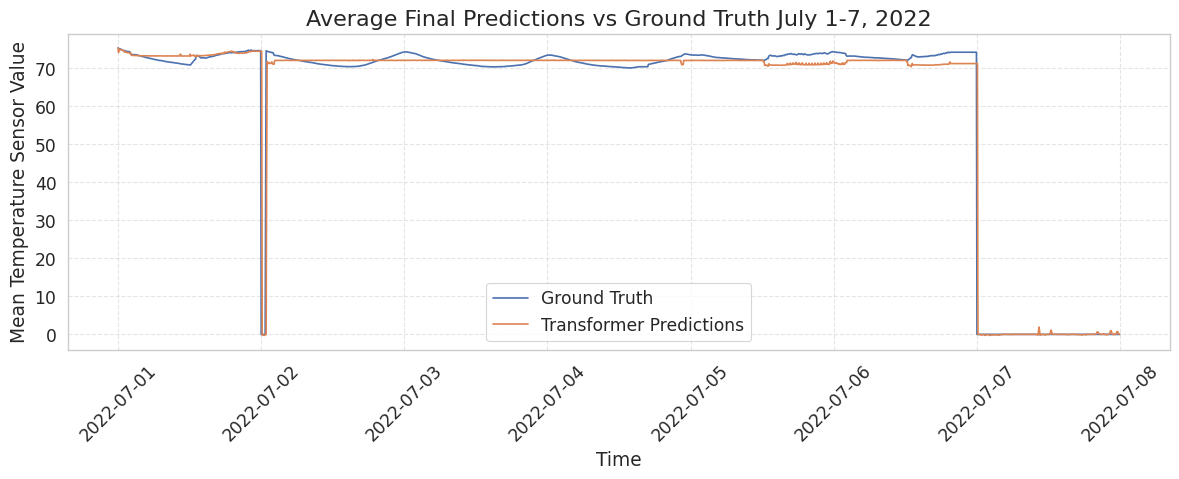

In [26]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Ensure reproducibility
sns.set(style='whitegrid', context='paper', font_scale=1.4)

# Simulated time axis: 5-minute intervals over one week (2016 points)
time_index = pd.date_range(start='2022-07-01', periods=2016, freq='5T')  # Start date arbitrary

# Convert data to numpy if it's PyTorch tensor
if isinstance(ground_truth_sequence, torch.Tensor):
    ground_truth_sequence = ground_truth_sequence.numpy()
if isinstance(final_predictions, torch.Tensor):
    final_predictions = final_predictions.numpy()

# Take mean over axis=1 for each time step
gt_mean = ground_truth_sequence.mean(axis=1)
pred_mean = final_predictions.mean(axis=1)

# Create a DataFrame for seaborn
df = pd.DataFrame({
    'Time': time_index,
    'Ground Truth': gt_mean,
    'Transformer Predictions': pred_mean
})

# Melt for seaborn
df_melted = df.melt(id_vars='Time', var_name='Type', value_name='Value')

# Plot
plt.figure(figsize=(12, 5))
sns.lineplot(data=df_melted, x='Time', y='Value', hue='Type')
plt.title('Average Final Predictions vs Ground Truth July 1-7, 2022', fontsize=16)
plt.xlabel('Time')
plt.ylabel('Mean Temperature Sensor Value')
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend(title='')
plt.grid(True, linestyle='--', alpha=0.5)
plt.savefig('transformer_forecast.png', dpi=300, bbox_inches='tight')
plt.show()